In [ ]:
#Modified/Adapted from: # https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [ ]:
#pip installs
!pip install cython
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-08y0mnck
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-08y0mnck
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263921 sha256=c672296ce6362e36226ce7242a75a7ca5d5ab0f0f4535da663a95c86c60f0df6
  Stored in directory: /tmp/pip-ephem-wheel-cache-_3wldl_f/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 23060, done.
remote: Counting objects: 100% (522/522), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 23060 (delta 349), reused 474 (delta 324), pack-reused 22538
Receiving objects: 100% (23060/23060), 29.53 MiB | 27.61 MiB/s, done.
Resolving deltas: 100% (17047/17047), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
#imports

import numpy as np
import pandas as pd
import os
import pycocotools
import torchvision
import torch
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
#File Upload Syntax: Sign_Images.zip, SL_Combined.csv (in content)

In [ ]:
#!unzip Sign_Images.zip
!unzip -o Sign_Images.zip


Archive:  Sign_Images.zip
   creating: Sign_Images/
  inflating: Sign_Images/26.0.png    
  inflating: Sign_Images/47.1.png    
  inflating: Sign_Images/5.0.png     
  inflating: Sign_Images/47.0.png    
  inflating: Sign_Images/45.0.png    
  inflating: Sign_Images/47.2.png    
  inflating: Sign_Images/7.0.png     
  inflating: Sign_Images/19.0.png    
  inflating: Sign_Images/47.3.png    
  inflating: Sign_Images/24.0.png    
  inflating: Sign_Images/58.0.png    
  inflating: Sign_Images/3.0.png     
  inflating: Sign_Images/47.7.png    
  inflating: Sign_Images/41.1.png    
  inflating: Sign_Images/43.3.png    
  inflating: Sign_Images/20.0.png    
  inflating: Sign_Images/20.1.png    
  inflating: Sign_Images/43.2.png    
  inflating: Sign_Images/41.0.png    
  inflating: Sign_Images/47.6.png    
  inflating: Sign_Images/39.0.png    
  inflating: Sign_Images/47.4.png    
  inflating: Sign_Images/43.0.png    
  inflating: Sign_Images/43.1.png    
  inflating: Sign_Images/22.0.png   

In [ ]:
dataset = pd.read_csv("SL_combined.csv")
filenames = dataset.filename.unique()

print(dataset)

    stroke   x1   y1   x2   y2  filename  wfile  hfile
0    Wedge   80  255  410  256   1.0.png    500    500
1    Wedge  176  178  405  380   2.0.png    500    500
2    Wedge  153  346  420  143   2.0.png    500    500
3    Wedge   49  258  468  257   2.0.png    500    500
4     Line   91  101   86  372   3.0.png    500    500
..     ...  ...  ...  ...  ...       ...    ...    ...
791  Wedge   14   70   91   68  58.0.png    240    172
792  Wedge  115   22   92  116  58.0.png    240    172
793  Wedge  142   67  138  123  58.0.png    240    172
794  Wedge  171   21  180  124  58.0.png    240    172
795  Wedge   53  133  212  127  58.0.png    240    172

[796 rows x 8 columns]


In [ ]:
def strokenum(s):
  if s == "Wedge":
    return 1
  elif s == "Winkel":
    return 2
  elif s == "Line":
    return 3
  else: raise Exception("Error: Invalid Stroke")

def linestack(x1,x2,y1,y2, w, h):
  xmin = np.maximum(0, np.minimum(x1,x2) - 20)
  ymin = np.maximum(0, np.minimum(y1,y2) - 20)
  xmax = np.minimum(w, np.maximum(x1,x2) + 20)
  ymax = np.minimum(h, np.maximum(y1,y2) + 20)
  return np.stack([xmin,ymin,xmax,ymax], axis=1)


In [ ]:
class SLDataset(object):
  def __init__(self, imgdir, labelset, transforms = None):
    self.transforms = transforms
    self.imgdir = imgdir
    self.imgs = list(sorted(os.listdir(imgdir)))#[1:]
    self.labelset = labelset

    #print(self.imgs)

  def __getitem__(self, idx):
    img_path = os.path.join(self.imgdir, self.imgs[idx])
    img = Image.open(img_path).convert("RGB")
    
    filter = self.labelset['filename'] == self.imgs[idx]
    labelsubset = self.labelset[filter]
    #print(len(labelsubset))

    name = self.imgs[idx].strip(.png)

    x1 = labelsubset.x1.to_numpy()
    y1 = labelsubset.y1.to_numpy()
    x2 = labelsubset.x2.to_numpy()
    y2 = labelsubset.y2.to_numpy()
    num_strokes = len(x1)

    imgh = labelsubset.hfile.to_numpy()
    imgw = labelsubset.wfile.to_numpy()

    boxes = linestack(x1=x1,x2=x2,y1=y1,y2=y2, w = imgw, h = imgh)
    # boxes = np.transpose(np.array([np.zeros(num_strokes), 
                                  #  np.zeros(num_strokes), 
                                  #  imgh, 
                                  #  imgw]))
    boxes = torch.as_tensor(boxes, dtype=torch.float32)


    pt1 = np.stack([x1,y1, np.ones_like(x1)], axis=1)
    pt2 = np.stack([x2,y2, np.ones_like(x1)], axis=1)
    fillers = np.zeros([num_strokes, 15, 3])
    kp = np.stack([pt1,pt2], axis=1)
    keypoints = np.pad(kp, [[0,0],[0,15],[0,0]])
    keypoints = torch.as_tensor(keypoints, dtype = torch.float32)

    area = torch.as_tensor(np.abs((x2-x1)*(y2-y1)), dtype=torch.float32)

    labels = labelsubset.stroke.to_numpy()
    labels = np.array([strokenum(s) for s in labels])
    # labels = np.ones(num_strokes)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    image_id = torch.tensor([idx])
    iscrowd = torch.zeros(num_strokes, dtype=torch.int64)


    target = {}
    target["boxes"] = boxes
    target["keypoints"] = keypoints
    target["labels"] = labels
    target["image_id"] = image_id
    target["iscrowd"] = iscrowd
    target["area"] = area
    target["name"] = name

    #print(boxes)
    
    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    # if train:
    #     transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

torch.Size([4, 17, 3])
torch.Size([4, 4])


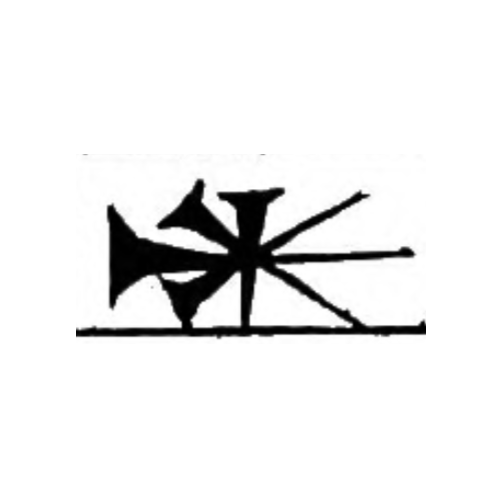

In [ ]:
data = SLDataset(imgdir="/content/Sign_Images", labelset=dataset, transforms=get_transform(train=True))
data_test = SLDataset(imgdir="/content/Sign_Images", labelset=dataset, transforms=get_transform(train=False))

sampleimg = data_test.__getitem__(2)

print((sampleimg[1]["keypoints"]).shape)
print((sampleimg[1]["boxes"]).shape)

#print(f'Sample Keypoint Shape: {sampleimg[1]["keypoints"].shape}')
Image.fromarray(sampleimg[0].mul(255).permute(1, 2, 0).byte().numpy())


In [ ]:
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                               num_classes = 4,)

torch.manual_seed(1)
indices = torch.randperm(len(data)).tolist()
data = torch.utils.data.Subset(data, indices[:-10])
data_test = torch.utils.data.Subset(data_test, indices[-10:])

data_loader = torch.utils.data.DataLoader(data, 
                                          batch_size=2, 
                                          shuffle=False, 
                                          num_workers=4, 
                                          collate_fn= utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(data_test, 
                                               batch_size=2, 
                                               shuffle=False, 
                                               num_workers=4, 
                                               collate_fn= utils.collate_fn)

images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

output = model(images, targets)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

# # our dataset has two classes only - background and person
# num_classes = 2

# # get the model using our helper function
# model = get_model_instance_segmentation(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.1)

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    # train for one epoch, printing every 20 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/44]  eta: 0:00:40  lr: 0.000121  loss: 10.2559 (10.2559)  loss_classifier: 1.3739 (1.3739)  loss_box_reg: 0.0192 (0.0192)  loss_keypoint: 8.0752 (8.0752)  loss_objectness: 0.6893 (0.6893)  loss_rpn_box_reg: 0.0983 (0.0983)  time: 0.9302  data: 0.4582  max mem: 5842
Epoch: [0]  [43/44]  eta: 0:00:00  lr: 0.005000  loss: 8.4573 (8.9675)  loss_classifier: 0.3570 (0.5821)  loss_box_reg: 0.4084 (0.2486)  loss_keypoint: 7.2922 (7.5823)  loss_objectness: 0.1843 (0.4052)  loss_rpn_box_reg: 0.1095 (0.1493)  time: 0.6604  data: 0.0070  max mem: 5842
Epoch: [0] Total time: 0:00:27 (0.6159 s / it)
creating index...
index created!
Test:  [0/5]  eta: 0:00:04  model_time: 0.5286 (0.5286)  evaluator_time: 0.0638 (0.0638)  time: 0.9889  data: 0.3938  max mem: 5842
Test:  [4/5]  eta: 0:00:00  model_time: 0.6299 (0.6003)  evaluator_time: 0.0558 (0.0555)  time: 0.7386  data: 0.0810  max mem: 5842
Test: Total time: 0:00:03 (0.7754 s / it)
Averaged stats: model_time: 0.6299 (0.6003)  evaluat

In [ ]:
# pick one image from the test set
img, _ = data_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
import torch

torch.save(model.state_dict(), f = 'model/model50')

In [ ]:
prediction

[{'boxes': tensor([[309.0508, 257.3672, 394.2439, 339.5001],
          [138.1013, 230.2396, 364.9337, 268.0019],
          [100.5866, 213.8671, 380.6671, 285.0186],
          [205.6380, 170.0270, 242.1938, 331.7180],
          [124.9093, 281.1366, 286.9935, 328.4197],
          [320.4006, 181.5035, 365.4022, 307.3905],
          [300.8047, 184.0745, 376.8240, 277.0277],
          [163.7681, 174.9920, 204.1945, 320.5340],
          [290.8782, 287.7425, 414.7714, 329.6610],
          [115.5836, 208.9839, 200.2748, 293.9933],
          [181.9940, 250.8494, 266.0351, 340.4410],
          [325.4673, 215.5592, 373.8947, 342.0349],
          [165.7313, 198.7851, 344.4016, 314.9083],
          [104.3403, 248.0247, 359.5681, 325.6263],
          [112.2404, 228.1901, 283.0302, 274.8589],
          [143.4312, 173.2082, 222.9687, 262.7339],
          [118.9341, 176.8256, 277.4769, 328.4122],
          [157.7176, 272.1635, 204.6462, 320.2932],
          [179.8030, 172.4038, 225.5971, 294.9243],
   

### Show Data_Test images

0


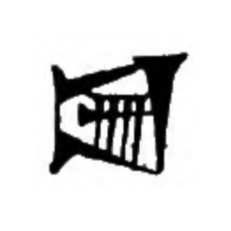

1


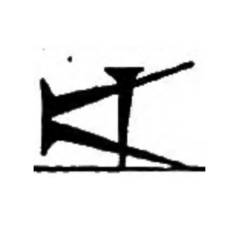

2


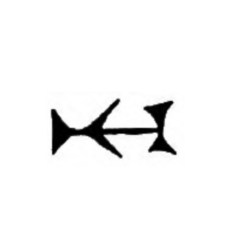

3


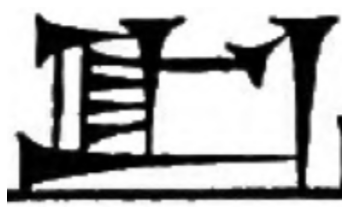

4


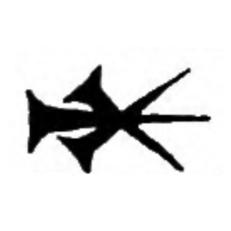

5


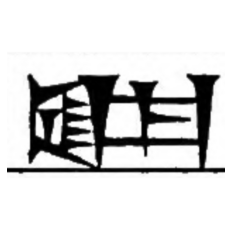

6


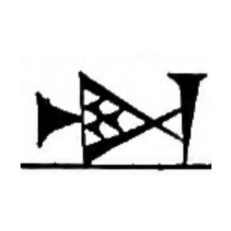

7


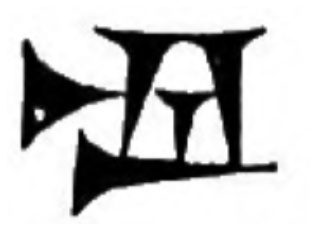

8


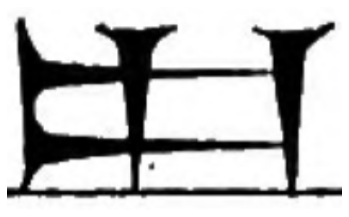

9


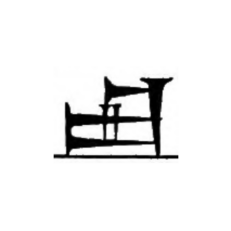

In [ ]:
for n in range(len(data_test)):
  print(n)
  sampleimg = data_test.__getitem__(n)
  plt.imshow(Image.fromarray(sampleimg[0].mul(255).permute(1, 2, 0).byte().numpy()))
  plt.axis('off')
  plt.show()


### Plot Results


[[ 0  1]
 [ 1  1]
 [ 2  1]
 [ 3  2]
 [ 4  1]
 [ 5  1]
 [ 6  1]
 [ 7  2]
 [ 8  1]
 [ 9  2]
 [10  1]
 [11  2]
 [12  1]
 [13  1]
 [14  1]
 [15  3]
 [16  1]
 [17  1]
 [18  1]
 [19  1]]


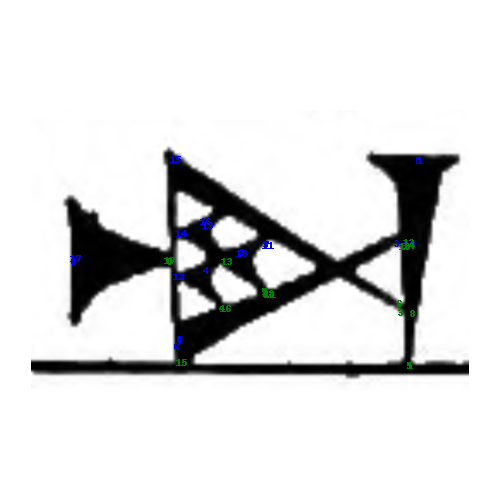

In [ ]:
# modified from: https://towardsdatascience.com/building-your-own-object-detector-pytorch-vs-tensorflow-and-how-to-even-get-started-1d314691d4ae

from PIL import ImageDraw

def boxsample(n, source, thr = 0.95, show = True):
  img, _ = source[n]
  model.eval()
  
  with torch.no_grad():
      prediction = model([img.to(device)])

  image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
  draw = ImageDraw.Draw(image)
  boxes = prediction[0]["boxes"].cpu().numpy()
  points = prediction[0]['keypoints'][:,:,:2].cpu().numpy()
  scores = np.round(prediction[0]["scores"].cpu().numpy(), 4)


  for element in range(len(boxes)):
    # box = boxes[element]
    point = points[element][:2]
    #print(f'{element}: {point}')
    score = scores[element]
    #print(points)
    
    if score > thr:
        # draw.rectangle([(box[0], box[1]), (box[2], box[3])], 
        # outline ="red", width =3,)
        draw.text(point[0], text = str(element), fill = 'blue', )
        draw.text(point[1], text = str(element), fill = 'green', )
        # draw.text((box[0], box[1]), text = str(score), fill=(0,150,0,255))
    #  else:
    #     draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
    #     outline ="blue", width =3)
    #     draw.text((boxes[0], boxes[1]), text = str(score))

  if show:
    plt.imshow(image)
    plt.axis('off')
    plt.show()

  return image, prediction

im, pred = boxsample(6, data_test, thr = 0.6, show = False)
pl = pred[0]['labels'].cpu().numpy()
strokes = range(len(pl))

print(np.stack((strokes, pl), axis = 1)[:20])

im

In [ ]:
def topsample(n, source, num = 5, show = True):
  img, _ = source[n]
  model.eval()
  
  with torch.no_grad():
      prediction = model([img.to(device)])

  image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
  draw = ImageDraw.Draw(image)

  boxes = prediction[0]["boxes"].cpu().numpy()
  points = prediction[0]['keypoints'][:,:,:2].cpu().numpy()
  scores = np.round(prediction[0]["scores"].cpu().numpy(), 4)

  num = min(len(boxes), num)
  inds = np.argsort(scores)[:num]

  boxsort = boxes[inds]
  pointsort = points[inds]
  scoresort = scores[inds]

  for element in range(num):
    box = boxsort[element]
    point = pointsort[element][:2]
    #print(f'{element}: {point}')
    score = scoresort[element]
    #print(points)
    
    #draw.rectangle([(box[0], box[1]), (box[2], box[3])], 
    #outline ="red", width =3,)
    draw.text(point[0], text = 'H', fill = 'blue', )
    draw.text(point[1], text = 'T', fill = 'green', )
    #draw.text((box[0], box[1]), text = str(score), fill=(0,150,0,255))

  if show:
    plt.imshow(image)
    plt.axis('off')
    plt.show()

  return image

for n in range(len(data_test)):
  _ = topsample(n, data_test, 5)

In [ ]:
#Checking that model loading works

model2 = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                               num_classes = 4,)
model2.load_state_dict(torch.load('model/model'))
model2.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 